In [1]:
from google.colab import drive

# The following command will prompt a URL for you to click and obtain the
# authorization code

drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
from pathlib import Path

DATA = Path("/content/drive/My Drive/EECS 6893/Project/data")

In [3]:
import json
import requests
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import os
from datetime import datetime

In [4]:
all_file = "train.csv"
train_all = pd.read_csv(DATA / all_file)

In [5]:
train_bit = train_all[train_all["Asset_ID"]==1].set_index("timestamp")
train_eth = train_all[train_all["Asset_ID"]==6].set_index("timestamp")
train_btc = train_all[train_all["Asset_ID"]==2].set_index("timestamp")
train_bnc = train_all[train_all["Asset_ID"]==0].set_index("timestamp")
train_eos = train_all[train_all["Asset_ID"]==5].set_index("timestamp")
train_ethc = train_all[train_all["Asset_ID"]==7].set_index("timestamp")
train_ltc = train_all[train_all["Asset_ID"]==9].set_index("timestamp")
train_mon = train_all[train_all["Asset_ID"]==11].set_index("timestamp")
train_tron = train_all[train_all["Asset_ID"]==13].set_index("timestamp")
train_ste = train_all[train_all["Asset_ID"]==12].set_index("timestamp")
train_car = train_all[train_all["Asset_ID"]==3].set_index("timestamp")
train_iota = train_all[train_all["Asset_ID"]==8].set_index("timestamp")
train_maker = train_all[train_all["Asset_ID"]==10].set_index("timestamp")
train_doge = train_all[train_all["Asset_ID"]==4].set_index("timestamp")

In [6]:
train_eth = train_eth.reindex(range(train_eth.index[0],train_eth.index[-1]+60,60),method='pad')
train_bit = train_bit.reindex(range(train_bit.index[0],train_bit.index[-1]+60,60),method='pad')
train_btc = train_btc.reindex(range(train_btc.index[0],train_bit.index[-1]+60,60),method='pad')
train_bnc = train_bnc.reindex(range(train_bnc.index[0],train_bit.index[-1]+60,60),method='pad')
train_eos = train_eos.reindex(range(train_eos.index[0],train_bit.index[-1]+60,60),method='pad')
train_ethc = train_ethc.reindex(range(train_ethc.index[0],train_bit.index[-1]+60,60),method='pad')
train_ltc = train_ltc.reindex(range(train_ltc.index[0],train_bit.index[-1]+60,60),method='pad')
train_mon = train_mon.reindex(range(train_mon.index[0],train_bit.index[-1]+60,60),method='pad')
train_tron = train_tron.reindex(range(train_tron.index[0],train_bit.index[-1]+60,60),method='pad')
train_ste = train_ste.reindex(range(train_ste.index[0],train_bit.index[-1]+60,60),method='pad')
train_car = train_car.reindex(range(train_car.index[0],train_bit.index[-1]+60,60),method='pad')
train_iota = train_iota.reindex(range(train_iota.index[0],train_bit.index[-1]+60,60),method='pad')
train_maker = train_maker.reindex(range(train_maker.index[0],train_bit.index[-1]+60,60),method='pad')
train_doge = train_doge.reindex(range(train_doge.index[0],train_bit.index[-1]+60,60),method='pad')

In [7]:
import time

# auxiliary function, from datetime to timestamp
totimestamp = lambda s: np.int32(time.mktime(datetime.strptime(s, "%d/%m/%Y").timetuple()))

In [8]:
period = 1440 # predict the closing price of the next day
training_period = 150*period
test_period = 30*period

open = list()
close = list()
high = list()
low = list()
volume = list()
temp = train_bit
for i in range(211):
  index = period*i+1
  close.append(temp.iloc[-index]['Close'])
  open.append(temp.iloc[-(period+index)]['Open'])
  high.append(max(temp.iloc[-(period+index):-index]['High']))
  low.append(min(temp.iloc[-(period+index):-index]['Low']))
  volume.append(sum(temp.iloc[-(period+index):-index]['Volume']))
data = {'open' : open[::-1],'close' : close[::-1],'high' : high[::-1],'low' : low[::-1],'volume' : volume[::-1]}
x_train = pd.DataFrame.from_dict(data)
x_train = x_train.iloc[:-1]
close = close[::-1]
x_train['ret'] = [i / j for i, j in zip(close[1:],close[:-1])]

In [9]:
s = (180,30)
open = np.zeros(s)
close = np.zeros(s)
high = np.zeros(s)
low = np.zeros(s)
volume = np.zeros(s)

for i in range(180):
  for j in range(30):
    open[i][j] = x_train.iloc[i+j]['open']
    close[i][j] = x_train.iloc[i+j]['close']
    high[i][j] = x_train.iloc[i+j]['high']
    low[i][j] = x_train.iloc[i+j]['low']
    volume[i][j] = x_train.iloc[i+j]['volume']

In [ ]:
len(open)

180

In [10]:
train = x_train.iloc[30:]
for i in range(30):
  train['open_'+str(i)] = open[:,i]
  train['close_'+str(i)] = close[:,i]
  train['high_'+str(i)] = high[:,i]
  train['low_'+str(i)] = low[:,i]
  train['volume_'+str(i)] = volume[:,i]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [11]:
train

,open,close,high,low,volume,ret,open_0,close_0,high_0,low_0,volume_0,open_1,close_1,high_1,low_1,volume_1,open_2,close_2,high_2,low_2,volume_2,open_3,close_3,high_3,low_3,volume_3,open_4,close_4,high_4,low_4,volume_4,open_5,close_5,high_5,low_5,volume_5,open_6,close_6,high_6,low_6,...,open_22,close_22,high_22,low_22,volume_22,open_23,close_23,high_23,low_23,volume_23,open_24,close_24,high_24,low_24,volume_24,open_25,close_25,high_25,low_25,volume_25,open_26,close_26,high_26,low_26,volume_26,open_27,close_27,high_27,low_27,volume_27,open_28,close_28,high_28,low_28,volume_28,open_29,close_29,high_29,low_29,volume_29
30,54345.577143,52346.672500,57212.00,51500.00,177440.137883,0.981276,57439.294286,54110.021429,58230.01,43456.78,294660.089982,54107.287453,48970.682857,55499.20,44000.00,392818.187922,48900.402857,49780.252857,51459.51,46902.00,191603.330925,49702.681429,46954.455714,52189.00,46624.40,173398.831800,47085.868571,46333.102355,48476.62,44027.00,231725.264031,46297.217143,45953.837143,48407.00,44836.50,123846.402120,46141.500000,45204.010000,46706.20,43000.00,...,55629.798750,57112.537143,56970.00,52500.00,160302.512364,56905.925090,59179.368750,59128.00,53752.00,147077.787349,58923.968750,57562.274286,60190.00,56996.15,135244.899604,57643.754286,58005.160000,59480.00,56071.00,105406.445059,58036.717143,58034.490000,60000.00,57545.20,87129.116299,58093.887143,57399.297701,58835.60,55357.00,99209.542498,57363.501429,54220.500000,58525.00,53250.03,129585.969487,54094.932484,54255.280386,55866.44,52812.00,121464.425468
31,52301.292500,51366.555714,53287.00,50305.00,182953.398363,1.075490,54107.287453,48970.682857,55499.20,44000.00,392818.187922,48900.402857,49780.252857,51459.51,46902.00,191603.330925,49702.681429,46954.455714,52189.00,46624.40,173398.831800,47085.868571,46333.102355,48476.62,44027.00,231725.264031,46297.217143,45953.837143,48407.00,44836.50,123846.402120,46141.500000,45204.010000,46706.20,43000.00,172727.649466,45122.987143,49623.045714,49831.52,44949.85,...,56905.925090,59179.368750,59128.00,53752.00,147077.787349,58923.968750,57562.274286,60190.00,56996.15,135244.899604,57643.754286,58005.160000,59480.00,56071.00,105406.445059,58036.717143,58034.490000,60000.00,57545.20,87129.116299,58093.887143,57399.297701,58835.60,55357.00,99209.542498,57363.501429,54220.500000,58525.00,53250.03,129585.969487,54094.932484,54255.280386,55866.44,52812.00,121464.425468,54345.577143,52346.672500,57212.00,51500.00,177440.137883
32,51316.734164,55244.201250,55125.13,51214.60,129541.248524,1.012330,48900.402857,49780.252857,51459.51,46902.00,191603.330925,49702.681429,46954.455714,52189.00,46624.40,173398.831800,47085.868571,46333.102355,48476.62,44027.00,231725.264031,46297.217143,45953.837143,48407.00,44836.50,123846.402120,46141.500000,45204.010000,46706.20,43000.00,172727.649466,45122.987143,49623.045714,49831.52,44949.85,174828.099362,49607.895714,48356.807500,50250.00,47047.60,...,58923.968750,57562.274286,60190.00,56996.15,135244.899604,57643.754286,58005.160000,59480.00,56071.00,105406.445059,58036.717143,58034.490000,60000.00,57545.20,87129.116299,58093.887143,57399.297701,58835.60,55357.00,99209.542498,57363.501429,54220.500000,58525.00,53250.03,129585.969487,54094.932484,54255.280386,55866.44,52812.00,121464.425468,54345.577143,52346.672500,57212.00,51500.00,177440.137883,52301.292500,51366.555714,53287.00,50305.00,182953.398363
33,55051.730000,55925.350000,56700.36,53948.35,96138.490413,0.998094,49702.681429,46954.455714,52189.00,46624.40,173398.831800,47085.868571,46333.102355,48476.62,44027.00,231725.264031,46297.217143,45953.837143,48407.00,44836.50,123846.402120,46141.500000,45204.010000,46706.20,43000.00,172727.649466,45122.987143,49623.045714,49831.52,44949.85,174828.099362,49607.895714,48356.807500,50250.00,47047.60,131375.550509,48462.501250,50192.809612,52666.00,48100.00,...,57643.754286,58005.160000,59480.00,56071.00,105406.445059,58036.717143,58034.490000,60000.00,57545.20,87129.116299,58093.887143,5

In [12]:
!pip install h2o

     |████████████████████████████████| 175.8 MB 32 kB/s 
  Created wheel for h2o: filename=h2o-3.34.0.3-py2.py3-none-any.whl size=175832480 sha256=e3d9284c77ee696533b5adc8073cb478d425cdc5e1a2bc6f9d80366b9360e872
  Stored in directory: /root/.cache/pip/wheels/2a/52/cf/01f6938288f0731963463ff72510db67f9f3076f801038b2f7
Successfully built h2o


In [13]:
import h2o
from h2o.automl import H2OAutoML

In [14]:
h2o.init(
    nthreads=-1
)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.11" 2021-04-20; OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04); OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmproc6904x
  JVM stdout: /tmp/tmproc6904x/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmproc6904x/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,2 months and 10 days
H2O_cluster_name:,H2O_from_python_unknownUser_7o5msu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [ ]:
train.shape

(180, 156)

In [ ]:
train = h2o.H2OFrame(train)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
x = train.columns
y = 'ret'
x.remove(y)
len(x)

155

In [ ]:
aml = H2OAutoML(seed=1)
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |██
04:02:32.278: Skipping training of model GBM_1_AutoML_1_20211217_40223 due to exception: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: GBM_1_AutoML_1_20211217_40223.  Details: ERRR on field: _min_rows: The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 180.0.


█████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_5_AutoML_1_20211217_40223

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.0017295461491235848
RMSE: 0.04158781250707453
MAE: 0.03082434667481316
RMSLE: 0.020842850324944404
R^2: -9.052758542793526e-13
Mean Residual Deviance: 0.0017295461491235848
Null degrees of freedom: 179
Residual degrees of freedom: 179
Null deviance: 0.31131830684224554
Residual deviance

In [ ]:
lb = aml.leaderboard

In [ ]:
lb

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
DeepLearning_grid_3_AutoML_5_20211216_202200_model_2,0.00170777,0.0413251,0.00170777,0.0311888,0.0207088
StackedEnsemble_BestOfFamily_5_AutoML_5_20211216_202200,0.0017319,0.0416161,0.0017319,0.0308289,0.0208563
StackedEnsemble_BestOfFamily_9_AutoML_5_20211216_202200,0.00173284,0.0416273,0.00173284,0.0308189,0.0208632
StackedEnsemble_AllModels_3_AutoML_5_20211216_202200,0.00173372,0.0416379,0.00173372,0.0308232,0.0208683
StackedEnsemble_BestOfFamily_4_AutoML_5_20211216_202200,0.00173857,0.0416962,0.00173857,0.030927,0.020896
StackedEnsemble_BestOfFamily_1_AutoML_5_20211216_202200,0.00174206,0.041738,0.00174206,0.0309649,0.0209169
StackedEnsemble_BestOfFamily_3_AutoML_5_20211216_202200,0.00174602,0.0417854,0.00174602,0.0309308,0.0209413
StackedEnsemble_AllModels_1_AutoML_5_20211216_202200,0.00174662,0.0417926,0.00174662,0.0310242,0.0209438
StackedEnsemble_BestOfFamily_8_AutoML_5_20211216_202200,0.00175609,0.0419057,0.00175609,0.0310697,0.0210046
StackedEnsemble_BestOfFamily_2_AutoML_5_20211216_202200,0.00175618,0.0419068,0.00175618,0.0311579,0.0210022


In [ ]:
preds = aml.leader.predict(train)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


In [ ]:
xcom = train.as_data_frame()

In [ ]:
ycom = preds.as_data_frame()

In [ ]:
aml.leader.model_performance(train)


ModelMetricsRegression: deeplearning
** Reported on test data. **

MSE: 0.00043369222288391196
RMSE: 0.02082527845873644
MAE: 0.015727705844470936
RMSLE: 0.010490940722160677
Mean Residual Deviance: 0.00043369222288391196


In [ ]:
z = (xcom['ret']-ycom['predict'])/xcom['ret']
z.mean()

-0.005515772441443437

In [ ]:
aml.leader

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_3_AutoML_5_20211216_202200_model_2


Status of Neuron Layers: predicting ret, regression, gaussian distribution, Quadratic loss, 12,951 weights/biases, 175.6 KB, 689,400 training samples, mini-batch size 1


,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,155,Input,20,,,,,,,,,
1,,2,50,RectifierDropout,40,0,0,0.0426327,0.035463,0,0.0169316,0.500374,-3.3365,0.801615
2,,3,50,RectifierDropout,40,0,0,0.00599946,0.0043685,0,-0.105893,0.217114,0.680881,0.66014
3,,4,50,RectifierDropout,40,0,0,0.0213487,0.0247596,0,-0.121964,0.235827,0.922392,0.522976
4,,5,1,Linear,,0,0,0.0025852,0.0033706,0,0.0143631,0.123947,0.120971,1.09713e-154




ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.00043369222288391196
RMSE: 0.02082527845873644
MAE: 0.01572770584447094
RMSLE: 0.010490940722160676
Mean Residual Deviance: 0.00043369222288391196

ModelMetricsRegression: deeplearning
** Reported on cross-validation data. **

MSE: 0.0017077677203078626
RMSE: 0.041325146343453675
MAE: 0.031188766713238725
RMSLE: 0.020708784385081072
Mean Residual Deviance: 0.0017077677203078626

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,0.031189,0.002560,0.030668,0.035320,0.028638,0.029708,0.031610
1,mean_residual_deviance,0.001708,0.000367,0.001795,0.002302,0.001356,0.001559,0.001527
2,mse,0.001708,0.000367,0.001795,0.002302,0.001356,0.001559,0.001527
3,r2,-0.008772,0.079170,0.026537,-0.144240,0.001888,0.062002,0.009953
4,residual_deviance,0.001708,0.000367,0.001795,0.002302,0.001356,0.001559,0.001527
5,rmse,0.041146,0.004297,0.042372,0.047975,0.036824,0.039486,0.039073
6,rmsle,0.020629,0.002036,0.021276,0.023794,0.018456,0.020001,0.019616



Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2
0,,2021-12-16 21:14:07,0.000 sec,None,0.0,0,0.0,NaN,NaN,NaN,NaN
1,,2021-12-16 21:14:07,3 min 42.803 sec,16363 obs/sec,10.0,1,1800.0,0.041426,0.001716,0.030834,0.007765
2,,2021-12-16 21:14:12,3 min 47.846 sec,26928 obs/sec,770.0,77,138600.0,0.022364,0.000500,0.016664,0.710834
3,,2021-12-16 21:14:17,3 min 52.922 sec,28716 obs/sec,1630.0,163,293400.0,0.020575,0.000423,0.015136,0.755242
4,,2021-12-16 21:14:22,3 min 57.958 sec,29984 obs/sec,2540.0,254,457200.0,0.017922,0.000321,0.013231,0.814284
5,,2021-12-16 21:14:27,4 min 2.961 sec,30939 obs/sec,3480.0,348,626400.0,0.019999,0.000400,0.014998,0.768738
6,,2021-12-16 21:14:29,4 min 4.857 sec,31142 obs/sec,3830.0,383,689400.0,0.020825,0.000434,0.015728,0.749245



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,volume_8,1.000000,1.000000,0.018410
1,volume_4,0.949987,0.949987,0.017490
2,volume_1,0.935911,0.935911,0.017231
3,volume_24,0.913102,0.913102,0.016811
4,volume_22,0.887725,0.887725,0.016343
5,volume_10,0.857122,0.857122,0.015780
6,volume_11,0.844760,0.844760,0.015552
7,volume_21,0.811773,0.811773,0.014945
8,volume_15,0.801800,0.801800,0.014761
9,volume_3,0.798145,0.798145,0.014694



See the whole table with table.as_data_frame()


In [15]:
period = 1440 # predict the closing price of the next day
training_period = 150*period
test_period = 30*period

open = list()
close = list()
high = list()
low = list()
volume = list()
temp = train_bit
for i in range(211):
  index = period*i+1
  close.append(temp.iloc[-index]['Close'])
  open.append(temp.iloc[-(period+index)]['Open'])
  high.append(max(temp.iloc[-(period+index):-index]['High']))
  low.append(min(temp.iloc[-(period+index):-index]['Low']))
  volume.append(sum(temp.iloc[-(period+index):-index]['Volume']))
data = {'open' : open[::-1],'close' : close[::-1],'high' : high[::-1],'low' : low[::-1],'volume' : volume[::-1]}
x_train = pd.DataFrame.from_dict(data)
x_train = x_train.iloc[:-1]
close = close[::-1]
x_train['ret'] = [i / j for i, j in zip(close[1:],close[:-1])]

In [16]:
train = h2o.H2OFrame(x_train)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
aml.leader.model_performance(train)


ModelMetricsRegression: deeplearning
** Reported on test data. **

MSE: 0.002640517067303061
RMSE: 0.05138596177267738
MAE: 0.03841431192787066
RMSLE: 0.025505601090658265
Mean Residual Deviance: 0.002640517067303061


In [ ]:
x_train.drop('ret',axis=1)
x_train.head()

,open,close,high,low,volume,ret
181,48846.545714,49306.915767,49540.01,48021.1,65499.746516,1.002980
182,49270.812500,49453.830079,50562.11,49002.8,95595.347148,0.965736
183,49502.324286,47759.343750,49897.10,45000.0,93866.502303,1.025595
184,47679.059438,48981.725000,49277.00,47100.0,80694.548375,0.954917
185,48988.687596,46773.489004,49387.60,46250.0,96183.913851,1.049214


In [ ]:
x_train = x_train.iloc[181:]

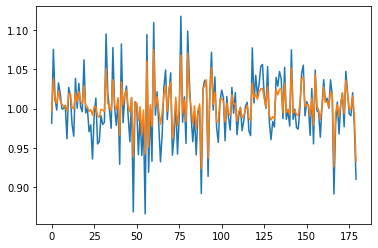

In [ ]:
plt.plot(xcom['ret'])
plt.plot(ycom['predict'])

In [17]:
period = 1440 # predict the closing price of the next day
training_period = 150*period
test_period = 30*period

open = list()
close = list()
high = list()
low = list()
volume = list()
temp = train_bit
for i in range(211):
  index = period*i+1
  close.append(temp.iloc[-index]['Close'])
  open.append(temp.iloc[-(period+index)]['Open'])
  high.append(max(temp.iloc[-(period+index):-index]['High']))
  low.append(min(temp.iloc[-(period+index):-index]['Low']))
  volume.append(sum(temp.iloc[-(period+index):-index]['Volume']))
data = {'open' : open[::-1],'close' : close[::-1],'high' : high[::-1],'low' : low[::-1],'volume' : volume[::-1]}
x_train = pd.DataFrame.from_dict(data)
x_train = x_train.iloc[:-1]
close = close[::-1]
x_train['ret'] = close[1:]

In [18]:
s = (180,30)
open = np.zeros(s)
close = np.zeros(s)
high = np.zeros(s)
low = np.zeros(s)
volume = np.zeros(s)

for i in range(180):
  for j in range(30):
    open[i][j] = x_train.iloc[i+j]['open']
    close[i][j] = x_train.iloc[i+j]['close']
    high[i][j] = x_train.iloc[i+j]['high']
    low[i][j] = x_train.iloc[i+j]['low']
    volume[i][j] = x_train.iloc[i+j]['volume']

In [19]:
train = x_train.iloc[30:]
for i in range(30):
  train['open_'+str(i)] = open[:,i]
  train['close_'+str(i)] = close[:,i]
  train['high_'+str(i)] = high[:,i]
  train['low_'+str(i)] = low[:,i]
  train['volume_'+str(i)] = volume[:,i]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [20]:
train

,open,close,high,low,volume,ret,open_0,close_0,high_0,low_0,volume_0,open_1,close_1,high_1,low_1,volume_1,open_2,close_2,high_2,low_2,volume_2,open_3,close_3,high_3,low_3,volume_3,open_4,close_4,high_4,low_4,volume_4,open_5,close_5,high_5,low_5,volume_5,open_6,close_6,high_6,low_6,...,open_22,close_22,high_22,low_22,volume_22,open_23,close_23,high_23,low_23,volume_23,open_24,close_24,high_24,low_24,volume_24,open_25,close_25,high_25,low_25,volume_25,open_26,close_26,high_26,low_26,volume_26,open_27,close_27,high_27,low_27,volume_27,open_28,close_28,high_28,low_28,volume_28,open_29,close_29,high_29,low_29,volume_29
30,54345.577143,52346.672500,57212.00,51500.00,177440.137883,51366.555714,57439.294286,54110.021429,58230.01,43456.78,294660.089982,54107.287453,48970.682857,55499.20,44000.00,392818.187922,48900.402857,49780.252857,51459.51,46902.00,191603.330925,49702.681429,46954.455714,52189.00,46624.40,173398.831800,47085.868571,46333.102355,48476.62,44027.00,231725.264031,46297.217143,45953.837143,48407.00,44836.50,123846.402120,46141.500000,45204.010000,46706.20,43000.00,...,55629.798750,57112.537143,56970.00,52500.00,160302.512364,56905.925090,59179.368750,59128.00,53752.00,147077.787349,58923.968750,57562.274286,60190.00,56996.15,135244.899604,57643.754286,58005.160000,59480.00,56071.00,105406.445059,58036.717143,58034.490000,60000.00,57545.20,87129.116299,58093.887143,57399.297701,58835.60,55357.00,99209.542498,57363.501429,54220.500000,58525.00,53250.03,129585.969487,54094.932484,54255.280386,55866.44,52812.00,121464.425468
31,52301.292500,51366.555714,53287.00,50305.00,182953.398363,55244.201250,54107.287453,48970.682857,55499.20,44000.00,392818.187922,48900.402857,49780.252857,51459.51,46902.00,191603.330925,49702.681429,46954.455714,52189.00,46624.40,173398.831800,47085.868571,46333.102355,48476.62,44027.00,231725.264031,46297.217143,45953.837143,48407.00,44836.50,123846.402120,46141.500000,45204.010000,46706.20,43000.00,172727.649466,45122.987143,49623.045714,49831.52,44949.85,...,56905.925090,59179.368750,59128.00,53752.00,147077.787349,58923.968750,57562.274286,60190.00,56996.15,135244.899604,57643.754286,58005.160000,59480.00,56071.00,105406.445059,58036.717143,58034.490000,60000.00,57545.20,87129.116299,58093.887143,57399.297701,58835.60,55357.00,99209.542498,57363.501429,54220.500000,58525.00,53250.03,129585.969487,54094.932484,54255.280386,55866.44,52812.00,121464.425468,54345.577143,52346.672500,57212.00,51500.00,177440.137883
32,51316.734164,55244.201250,55125.13,51214.60,129541.248524,55925.350000,48900.402857,49780.252857,51459.51,46902.00,191603.330925,49702.681429,46954.455714,52189.00,46624.40,173398.831800,47085.868571,46333.102355,48476.62,44027.00,231725.264031,46297.217143,45953.837143,48407.00,44836.50,123846.402120,46141.500000,45204.010000,46706.20,43000.00,172727.649466,45122.987143,49623.045714,49831.52,44949.85,174828.099362,49607.895714,48356.807500,50250.00,47047.60,...,58923.968750,57562.274286,60190.00,56996.15,135244.899604,57643.754286,58005.160000,59480.00,56071.00,105406.445059,58036.717143,58034.490000,60000.00,57545.20,87129.116299,58093.887143,57399.297701,58835.60,55357.00,99209.542498,57363.501429,54220.500000,58525.00,53250.03,129585.969487,54094.932484,54255.280386,55866.44,52812.00,121464.425468,54345.577143,52346.672500,57212.00,51500.00,177440.137883,52301.292500,51366.555714,53287.00,50305.00,182953.398363
33,55051.730000,55925.350000,56700.36,53948.35,96138.490413,55818.774286,49702.681429,46954.455714,52189.00,46624.40,173398.831800,47085.868571,46333.102355,48476.62,44027.00,231725.264031,46297.217143,45953.837143,48407.00,44836.50,123846.402120,46141.500000,45204.010000,46706.20,43000.00,172727.649466,45122.987143,49623.045714,49831.52,44949.85,174828.099362,49607.895714,48356.807500,50250.00,47047.60,131375.550509,48462.501250,50192.809612,52666.00,48100.00,...,57643.754286,58005.160000,59480.00,56071.00,105406.445059,58036.717143,58034.490000,60000.00,57545.20,87129.11629

In [21]:
train = h2o.H2OFrame(train)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [22]:
x = train.columns
y = 'ret'
x.remove(y)
len(x)

155

In [23]:
train, valid = train.split_frame(ratios = [.8], seed = 1234)

In [24]:
len(valid)

35

In [25]:
aml = H2OAutoML(seed=1,max_runtime_secs=600)
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |██
21:50:36.927: Skipping training of model GBM_1_AutoML_1_20211217_215029 due to exception: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: GBM_1_AutoML_1_20211217_215029.  Details: ERRR on field: _min_rows: The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 145.0.


█████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid_1_AutoML_1_20211217_215029_model_40


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,52925.0,7.0,7.0,7.0,66.0,94.0,79.7




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 2180.725457763672
RMSE: 46.698238272590885
MAE: 40.28930495689655
RMSLE: 0.001115121259198523
Mean Residual Deviance: 2180.725457763672

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 3185884.302648494
RMSE: 1784.9045640169377
MAE: 1400.2607777182916
RMSLE: 0.04125780362368694
Mean Residual Deviance: 3185884.302648494

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,1.399257e+03,121.193540,1.288825e+03,1.338910e+03,1.324554e+03,1.461987e+03,1.582011e+03
1,mean_residual_deviance,3.193135e+06,823426.700000,2.700046e+06,2.964185e+06,2.509207e+06,3.203138e+06,4.589098e+06
2,mse,3.193135e+06,823426.700000,2.700046e+06,2.964185e+06,2.509207e+06,3.203138e+06,4.589098e+06
3,r2,9.595886e-01,0.010117,9.674422e-01,9.606223e-01,9.689165e-01,9.573288e-01,9.436333e-01
4,residual_deviance,3.193135e+06,823426.700000,2.700046e+06,2.964185e+06,2.509207e+06,3.203138e+06,4.589098e+06
5,rmse,1.776172e+03,218.941240,1.643182e+03,1.721681e+03,1.584048e+03,1.789731e+03,2.142218e+03
6,rmsle,4.126257e-02,0.003383,3.849126e-02,4.131501e-02,3.832370e-02,4.149673e-02,4.668614e-02



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2021-12-17 21:56:27,2 min 27.019 sec,0.0,8893.368319,7755.522465,7.909200e+07
1,,2021-12-17 21:56:27,2 min 27.132 sec,5.0,5256.330370,4579.951199,2.762901e+07
2,,2021-12-17 21:56:27,2 min 27.235 sec,10.0,3106.319023,2704.514911,9.649218e+06
3,,2021-12-17 21:56:27,2 min 27.361 sec,15.0,1836.379495,1597.369706,3.372290e+06
4,,2021-12-17 21:56:27,2 min 27.465 sec,20.0,1085.639039,943.442443,1.178612e+06
5,,2021-12-17 21:56:27,2 min 27.564 sec,25.0,642.316984,557.287540,4.125711e+05
6,,2021-12-17 21:56:27,2 min 27.708 sec,30.0,379.902101,329.292336,1.443256e+05
7,,2021-12-17 21:56:27,2 min 27.852 sec,35.0,224.698712,194.620393,5.048951e+04
8,,2021-12-17 21:56:28,2 min 27.951 sec,40.0,133.113155,115.044073,1.771911e+04
9,,2021-12-17 21:56:28,2 min 28.064 sec,45.0,78.884416,68.086422,6.222751e+03



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,close,2.538312e+10,1.000000,0.420543
1,close_29,1.088495e+10,0.428826,0.180340
2,open,6.394892e+09,0.251935,0.105949
3,high,6.219797e+09,0.245037,0.103048
4,high_29,3.632739e+09,0.143116,0.060187
5,low,2.687866e+09,0.105892,0.044532
6,open_29,8.682898e+08,0.034207,0.014386
7,close_27,5.019097e+08,0.019773,0.008316
8,low_29,3.703889e+08,0.014592,0.006137
9,close_28,2.055151e+08,0.008097,0.003405



See the whole table with table.as_data_frame()


In [26]:
lb = aml.leaderboard
lb

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_grid_1_AutoML_1_20211217_215029_model_40,3.18588e+06,1784.9,3.18588e+06,1400.26,0.0412578
StackedEnsemble_BestOfFamily_3_AutoML_1_20211217_215029,3.24997e+06,1802.77,3.24997e+06,1401.59,0.0417925
XRT_1_AutoML_1_20211217_215029,3.25193e+06,1803.31,3.25193e+06,1402.97,0.0420268
StackedEnsemble_BestOfFamily_4_AutoML_1_20211217_215029,3.26109e+06,1805.85,3.26109e+06,1412.47,0.0415291
GBM_grid_1_AutoML_1_20211217_215029_model_53,3.28033e+06,1811.17,3.28033e+06,1404.5,0.0410578
GBM_grid_1_AutoML_1_20211217_215029_model_17,3.31211e+06,1819.92,3.31211e+06,1412.06,0.0414751
GBM_grid_1_AutoML_1_20211217_215029_model_15,3.33287e+06,1825.61,3.33287e+06,1408.49,0.0420137
GBM_grid_1_AutoML_1_20211217_215029_model_41,3.41259e+06,1847.32,3.41259e+06,1428.75,0.0418568
GBM_grid_1_AutoML_1_20211217_215029_model_8,3.42311e+06,1850.16,3.42311e+06,1440.44,0.0427978
DRF_1_AutoML_1_20211217_215029,3.47807e+06,1864.96,3.47807e+06,1434.09,0.0427284


In [27]:
preds = aml.leader.predict(valid)
xcom = valid.as_data_frame()
ycom = preds.as_data_frame()
aml.leader.model_performance(valid)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 7826288.331644895
RMSE: 2797.550416282948
MAE: 2209.9072762580636
RMSLE: 0.05754153632819961
Mean Residual Deviance: 7826288.331644895


In [28]:
z = (xcom['ret']-ycom['predict'])/xcom['ret']
aml.leader

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid_1_AutoML_1_20211217_215029_model_40


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,52925.0,7.0,7.0,7.0,66.0,94.0,79.7




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 2180.725457763672
RMSE: 46.698238272590885
MAE: 40.28930495689655
RMSLE: 0.001115121259198523
Mean Residual Deviance: 2180.725457763672

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 3185884.302648494
RMSE: 1784.9045640169377
MAE: 1400.2607777182916
RMSLE: 0.04125780362368694
Mean Residual Deviance: 3185884.302648494

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,1.399257e+03,121.193540,1.288825e+03,1.338910e+03,1.324554e+03,1.461987e+03,1.582011e+03
1,mean_residual_deviance,3.193135e+06,823426.700000,2.700046e+06,2.964185e+06,2.509207e+06,3.203138e+06,4.589098e+06
2,mse,3.193135e+06,823426.700000,2.700046e+06,2.964185e+06,2.509207e+06,3.203138e+06,4.589098e+06
3,r2,9.595886e-01,0.010117,9.674422e-01,9.606223e-01,9.689165e-01,9.573288e-01,9.436333e-01
4,residual_deviance,3.193135e+06,823426.700000,2.700046e+06,2.964185e+06,2.509207e+06,3.203138e+06,4.589098e+06
5,rmse,1.776172e+03,218.941240,1.643182e+03,1.721681e+03,1.584048e+03,1.789731e+03,2.142218e+03
6,rmsle,4.126257e-02,0.003383,3.849126e-02,4.131501e-02,3.832370e-02,4.149673e-02,4.668614e-02



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2021-12-17 21:56:27,2 min 27.019 sec,0.0,8893.368319,7755.522465,7.909200e+07
1,,2021-12-17 21:56:27,2 min 27.132 sec,5.0,5256.330370,4579.951199,2.762901e+07
2,,2021-12-17 21:56:27,2 min 27.235 sec,10.0,3106.319023,2704.514911,9.649218e+06
3,,2021-12-17 21:56:27,2 min 27.361 sec,15.0,1836.379495,1597.369706,3.372290e+06
4,,2021-12-17 21:56:27,2 min 27.465 sec,20.0,1085.639039,943.442443,1.178612e+06
5,,2021-12-17 21:56:27,2 min 27.564 sec,25.0,642.316984,557.287540,4.125711e+05
6,,2021-12-17 21:56:27,2 min 27.708 sec,30.0,379.902101,329.292336,1.443256e+05
7,,2021-12-17 21:56:27,2 min 27.852 sec,35.0,224.698712,194.620393,5.048951e+04
8,,2021-12-17 21:56:28,2 min 27.951 sec,40.0,133.113155,115.044073,1.771911e+04
9,,2021-12-17 21:56:28,2 min 28.064 sec,45.0,78.884416,68.086422,6.222751e+03



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,close,2.538312e+10,1.000000,0.420543
1,close_29,1.088495e+10,0.428826,0.180340
2,open,6.394892e+09,0.251935,0.105949
3,high,6.219797e+09,0.245037,0.103048
4,high_29,3.632739e+09,0.143116,0.060187
5,low,2.687866e+09,0.105892,0.044532
6,open_29,8.682898e+08,0.034207,0.014386
7,close_27,5.019097e+08,0.019773,0.008316
8,low_29,3.703889e+08,0.014592,0.006137
9,close_28,2.055151e+08,0.008097,0.003405



See the whole table with table.as_data_frame()


Text(28, 2000, 'Acc = 93.2%')

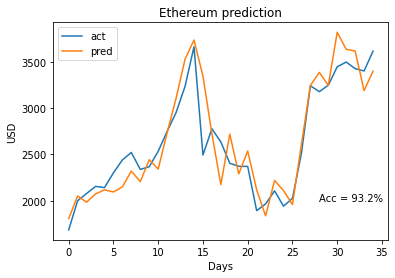

In [ ]:
plt.plot(xcom['ret'])
plt.plot(ycom['predict'])
plt.xlabel("Days")
plt.ylabel("USD")
plt.title('Ethereum prediction')
plt.legend(['act','pred'])
plt.text(28,2000,'Acc = 93.2%')

In [30]:
z = (xcom['ret']-ycom['predict'])/xcom['ret']
100*(1-np.mean(abs(z)))

95.33172732338483

Text(0, 40000, 'Acc = 95.3%')

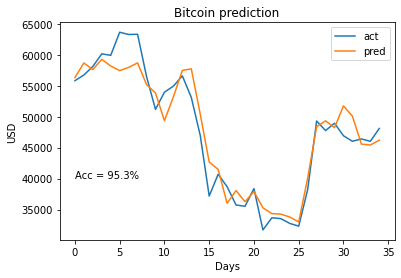

In [33]:
plt.plot(xcom['ret'])
plt.plot(ycom['predict'])
plt.xlabel("Days")
plt.ylabel("USD")
plt.title('Bitcoin prediction')
plt.legend(['act','pred'])
plt.text(0,40000,'Acc = 95.3%')

In [ ]:
period = 1440 # predict the closing price of the next day
training_period = 150*period
test_period = 30*period

open = list()
close = list()
high = list()
low = list()
volume = list()
temp = train_btc
for i in range(211):
  index = period*i+1
  close.append(temp.iloc[-index]['Close'])
  open.append(temp.iloc[-(period+index)]['Open'])
  high.append(max(temp.iloc[-(period+index):-index]['High']))
  low.append(min(temp.iloc[-(period+index):-index]['Low']))
  volume.append(sum(temp.iloc[-(period+index):-index]['Volume']))
data = {'open' : open[::-1],'close' : close[::-1],'high' : high[::-1],'low' : low[::-1],'volume' : volume[::-1]}
x_train = pd.DataFrame.from_dict(data)
x_train = x_train.iloc[:-1]
close = close[::-1]
x_train['ret'] = close[1:]
